In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installs
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install lets-plot
!pip install polars

In [ ]:
# Imports
import os
import cv2
import glob
import gdcm
import torch
import random
import pydicom
import torchvision
import numpy as np
import polars as pl
import torch.nn as nn
import statistics as stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.express as px

from PIL import Image
from lets_plot import *
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from lets_plot.mapping import as_discrete
from torch.utils.data import Dataset, DataLoader

# So the plots look nice
LetsPlot.setup_html()

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/Breast Cancer Dataset CSV/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Breast Cancer Dataset CSV/test.csv')
sample_submission_df = pd.read_csv('/content/drive/MyDrive/Breast Cancer Dataset CSV/sample_submission.csv')

In [ ]:
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [ ]:
person_age = train_df.groupby("patient_id")['age'].max().sort_index().fillna(0).astype('int64')

fig = px.histogram(person_age, title="Distribution of patients' age")
fig.show()

<Axes: xlabel='machine_id'>

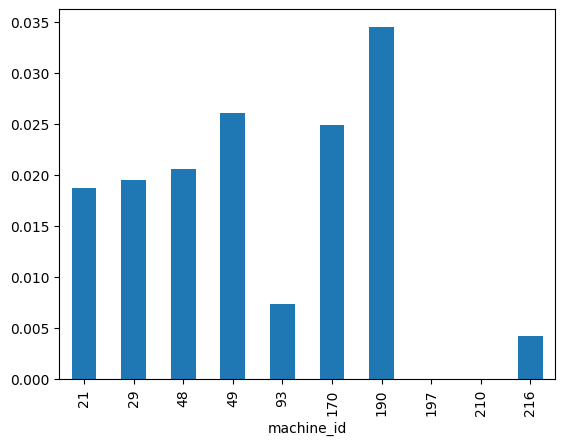

In [ ]:
# @title Proportion of Patients with Cancer by Machine ID
train_df.groupby('machine_id')['cancer'].mean().plot(kind='bar')

In [ ]:
test_df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


<ipython-input-9-73fbbd641c41>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




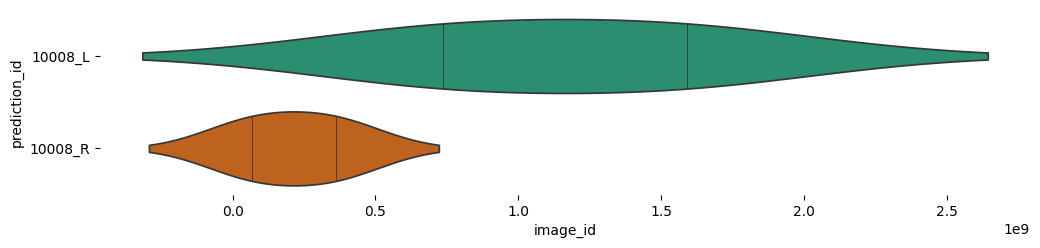

In [ ]:
# @title Prediction_id vs Image_id

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(test_df['prediction_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(test_df, x='image_id', y='prediction_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
sample_submission_df

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


<Axes: >

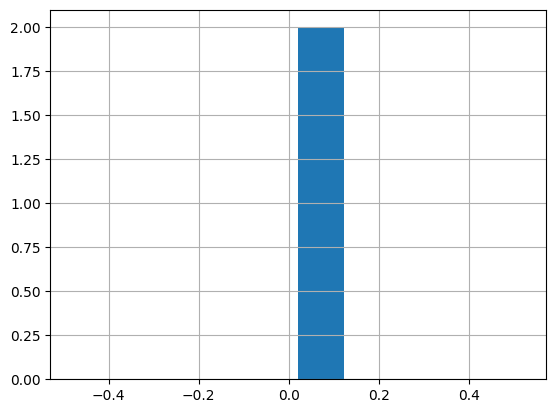

In [ ]:
# @title Distribution of cancer values
sample_submission_df['cancer'].hist()

In [ ]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [ ]:
sample_submission_df.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [ ]:
print(train_df.shape)
print(train_df.info())
print(train_df.head())

(54706, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1)

In [ ]:
print(test_df.shape)
print(test_df.info())
print(test_df.head())

(4, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
dtypes: int64(6), object(3)
memory usage: 416.0+ bytes
None
   site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119      

In [ ]:
print(train_df.columns)

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')


In [ ]:
print(train_df['cancer'].dtype)

int64


In [ ]:
train_df['cancer'] = train_df['cancer'].astype('object')

In [ ]:
print(train_df['cancer'].isna().sum())

0


In [ ]:
import plotly.express as px

images_counter = train_df["patient_id"].value_counts().sort_index()

fig = px.histogram(images_counter, title="Number of images per patient", labels={"index": "Patient ID", "value": "Number of Images"})
fig.update_layout(bargap=0.2)
fig.show()

In [ ]:
def plot_correlation_heatmap(df):
    df = pd.get_dummies(df, columns=['laterality', 'view', 'density'])
    df['difficult_negative_case'] = df['difficult_negative_case'].astype(int)

    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<ipython-input-33-03cb509afb4b>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



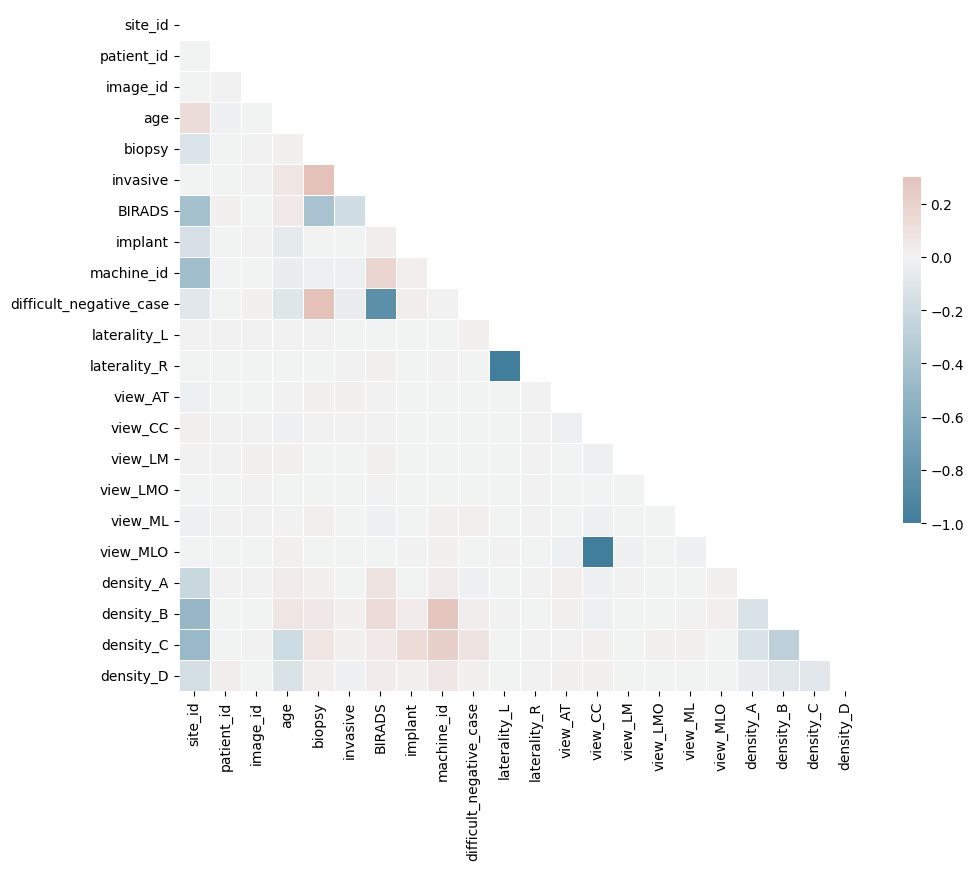

In [ ]:
plot_correlation_heatmap(train_df)

In [ ]:
train_df.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [ ]:
test_df.isna().sum()

site_id          0
patient_id       0
image_id         0
laterality       0
view             0
age              0
implant          0
machine_id       0
prediction_id    0
dtype: int64

In [ ]:
train_df.dropna(axis=1)

,site_id,patient_id,image_id,laterality,view,cancer,biopsy,invasive,implant,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,0,0,0,0,29,False
1,2,10006,1459541791,L,MLO,0,0,0,0,29,False
2,2,10006,1864590858,R,MLO,0,0,0,0,29,False
3,2,10006,1874946579,R,CC,0,0,0,0,29,False
4,2,10011,220375232,L,CC,0,0,0,0,21,True
...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,0,0,0,0,49,False
54702,1,9989,63473691,L,MLO,0,0,0,0,216,False
54703,1,9989,1078943060,L,CC,0,0,0,0,216,False
54704,1,9989,398038886,R,MLO,0,0,0,0,216,True


In [ ]:
test_df.dropna(axis=1)

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  object 
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [ ]:
train_df.var()

<ipython-input-50-470343d685a4>:1: FutureWarning:

The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



site_id                    2.484369e-01
patient_id                 3.569780e+08
image_id                   3.823282e+17
age                        1.010203e+02
cancer                     2.072000e-02
biopsy                     5.132742e-02
invasive                   1.472934e-02
BIRADS                     3.481736e-01
implant                    2.627041e-02
machine_id                 2.005678e+03
difficult_negative_case    1.210090e-01
dtype: float64

In [ ]:
train_df.corr()

<ipython-input-49-a7a80d20a44e>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,site_id,patient_id,image_id,age,biopsy,invasive,BIRADS,implant,machine_id,difficult_negative_case
site_id,1.000000,-0.001236,-0.000508,0.128149,-0.121886,-0.002603,-0.430987,-0.153870,-0.446908,-0.090292
patient_id,-0.001236,1.000000,0.001124,-0.011810,-0.005848,-0.003762,0.011424,-0.004338,-0.002665,-0.004221
image_id,-0.000508,0.001124,1.000000,-0.007483,0.001518,0.002657,-0.009201,0.004602,-0.006546,0.009850
age,0.128149,-0.011810,-0.007483,1.000000,0.010167,0.068674,0.048258,-0.069599,-0.050258,-0.104224
biopsy,-0.121886,-0.005848,0.001518,0.010167,1.000000,0.514311,-0.410620,-0.002569,-0.017580,0.323064
invasive,-0.002603,-0.003762,0.002657,0.068674,0.514311,1.000000,-0.172750,-0.008443,-0.018867,-0.049884
BIRADS,-0.430987,0.011424,-0.009201,0.048258,-0.410620,-0.172750,1.000000,0.025262,0.181352,-0.833624
implant,-0.153870,-0.004338,0.004602,-0.069599,-0.002569,-0.008443,0.025262,1.000000,0.018106,0.021065
machine_id,-0.446908,-0.002665,-0.006546,-0.050258,-0.017580,-0.018867,0.181352,0.018106,1.000000,0.000682
difficult_negative_case,-0.090292,-0.004221,0.009850,-0.104224,0.323064,-0.049884,-0.833624,0.021065,0.000682,1.000000


In [ ]:
train_df['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [ ]:
train_df['density'].value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

<Axes: xlabel='count', ylabel='density'>

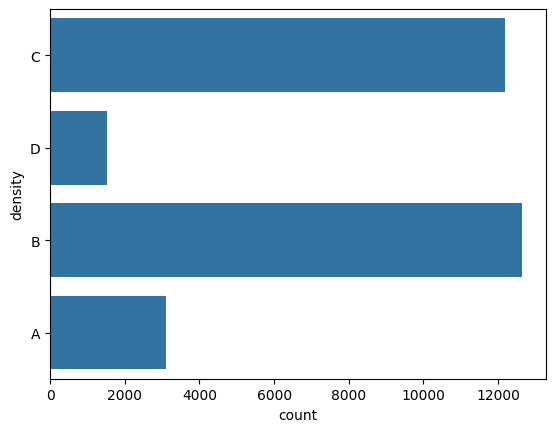

In [ ]:
sns.countplot(train_df['density'], label="count")